In [1]:
import random
from collections import deque
from typing import List, Tuple

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
import tensorflow as tf

import logging

# Get the logger instance
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)  # Set the minimum logging level

# Create a handler and set the formatter
handler = logging.FileHandler('hitori.log')
formatter = logging.Formatter('%(message)s')
handler.setFormatter(formatter)

# Add the handler to the logger
logger.addHandler(handler)

In [47]:
GameState = {
    "LOST": -1,
    "IN_PROGRESS": 0,
    "WON": 1,
}

def check_rule1(board: List[List[int]]) -> bool:
    size = len(board)
    for i in range(size):
        row_seen = set()
        col_seen = set()
        for j in range(size):
            row_val = board[i][j]
            col_val = board[j][i]
            if row_val != 0:
                if row_val in row_seen:
                    return False
                row_seen.add(row_val)
            if col_val != 0:
                if col_val in col_seen:
                    return False
                col_seen.add(col_val)
    return True

def check_rule2(mask: List[List[bool]]) -> bool:
    size = len(mask)
    for x in range(size):
        for y in range(size):
            if mask[x][y]:
                for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                    nx, ny = x + dx, y + dy
                    if 0 <= nx < size and 0 <= ny < size:
                        if mask[nx][ny]:
                            return False
    return True

def check_rule3(board: List[List[int]]) -> bool:
    size = len(board)
    visited = [[False] * size for _ in range(size)]

    for x in range(size):
        for y in range(size):
            if board[x][y] != 0:
                start = (x, y)
                break
        else:
            continue
        break
    else:
        return False

    queue = deque([start])
    visited[start[0]][start[1]] = True

    while queue:
        x, y = queue.popleft()
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < size and 0 <= ny < size:
                if not visited[nx][ny] and board[nx][ny] != 0:
                    visited[nx][ny] = True
                    queue.append((nx, ny))

    for x in range(size):
        for y in range(size):
            if board[x][y] != 0 and not visited[x][y]:
                return False
    return True

class HitoriGame:
    def __init__(self, board_size: int, seed: int = None):
        self.board_size = board_size
        self.seed = seed or random.randint(0, 9999999)
        random.seed(self.seed)

        self.solution_board = [[0] * board_size for _ in range(board_size)]
        self.solution_painted_mask = [[False] * board_size for _ in range(board_size)]
        self.player_painted_mask = [[False] * board_size for _ in range(board_size)]
        self.state = [[0] * board_size for _ in range(board_size)]

        self._generate_solution_board()
        self._initialize_player_board()
        self.status = GameState["IN_PROGRESS"]


    def _generate_solution_board(self):
        while True:
            # Step 1: initialize masks
            board = [[0] * self.board_size for _ in range(self.board_size)]
            painted = [[False] * self.board_size for _ in range(self.board_size)]

            # Step 2: randomly select non-adjacent painted cells
            num_painted = random.randint(13, 18) if self.board_size == 8 else max(1, self.board_size)
            attempts = 0
            while num_painted > 0 and attempts < 500:
                x = random.randint(0, self.board_size - 1)
                y = random.randint(0, self.board_size - 1)

                if painted[x][y]: continue
                # Check neighbors
                adjacent = False
                for dx, dy in [(-1,0), (1,0), (0,-1), (0,1)]:
                    nx, ny = x + dx, y + dy
                    if 0 <= nx < self.board_size and 0 <= ny < self.board_size:
                        if painted[nx][ny]:
                            adjacent = True
                            break
                if adjacent:
                    attempts += 1
                    continue

                painted[x][y] = True
                num_painted -= 1

            # Step 3: Create accumulators
            horiz_accum = [[False] * (self.board_size + 2) for _ in range(self.board_size)]
            vert_accum = [False] * (self.board_size + 2)

            success = True
            for x in range(self.board_size):
                vert_accum = [False] * (self.board_size + 2)
                total_choices = self.board_size + 1
                for y in range(self.board_size):
                    if painted[x][y]:
                        continue
                    attempts = 0
                    while attempts < 1000:
                        i = random.randint(1, self.board_size)
                        if not vert_accum[i] and not horiz_accum[y][i]:
                            board[x][y] = i
                            vert_accum[i] = True
                            horiz_accum[y][i] = True
                            break
                        attempts += 1
                    else:
                        success = False
                        break
                if not success:
                    break
            if not success:
                continue

            # Step 4: Fill painted cells with duplicates
            for x in range(self.board_size):
                for y in range(self.board_size):
                    if painted[x][y]:
                        candidates = [board[x][j] for j in range(self.board_size) if not painted[x][j] and board[x][j] != 0]
                        candidates += [board[i][y] for i in range(self.board_size) if not painted[i][y] and board[i][y] != 0]
                        if not candidates:
                            success = False
                            break
                        board[x][y] = random.choice(candidates)
                if not success:
                    break
            if not success:
                continue

            # Step 5: Build visible board
            visible = [[0 if painted[x][y] else board[x][y] for y in range(self.board_size)] for x in range(self.board_size)]
            if check_rule2(painted) and check_rule3(visible):
                # Finalize
                self.solution_board = board
                self.solution_painted_mask = painted
                return


    def _initialize_player_board(self):
        for x in range(self.board_size):
            for y in range(self.board_size):
                self.state[x][y] = self.solution_board[x][y]

    def print_solution_with_paint(self):
        print("Full Solution (with painted cells shown as X):")
        for y in range(self.board_size):
            row = []
            for x in range(self.board_size):
                if self.solution_painted_mask[x][y]:
                    row.append("X")
                else:
                    row.append(str(self.solution_board[x][y]))
            print(" ".join(row))
        print()

        solution_visible_board = [[
            0 if self.solution_painted_mask[x][y] else self.solution_board[x][y]
            for y in range(self.board_size)
        ] for x in range(self.board_size)]

        print("Checking solution board rules:")
        print(f"Rule 1 (no duplicates): {check_rule1(solution_visible_board)}")
        print(f"Rule 2 (no adjacent painted): {check_rule2(self.solution_painted_mask)}")
        print(f"Rule 3 (connected unpainted): {check_rule3(solution_visible_board)}\n")

    def print_state(self):
        print("Current Game Board:")
        for y in range(self.board_size):
            row = []
            for x in range(self.board_size):
                row.append("X" if self.player_painted_mask[x][y] else str(self.state[x][y]))
            print(" ".join(row))
        print(f"Status: {self.status}  (−1 = lost, 0 = in progress, 1 = won)\n")

    def check_loss(self) -> Tuple[bool, List[int]]:
        """
        Check if player violates Rule 2 or Rule 3.
        Returns (True, [rule_numbers]) if any violated.
        """
        broken = []
        if not check_rule2(self.player_painted_mask):
            broken.append(2)
        if not check_rule3(self.state):
            broken.append(3)
        return (len(broken) > 0, broken)


    def check_win(self) -> bool:
        """Return True if the player satisfies all 3 rules."""
        return (
            check_rule1(self.state)
            and check_rule2(self.player_painted_mask)
            and check_rule3(self.state)
        )

    def check_for_duplicates(self) -> bool:
        """Return True if any row or column has a duplicate number."""
        return(check_rule1(self.state))

    def is_valid_move(self, x: int, y: int) -> bool:
        return not self.player_painted_mask[x][y]

    def get_valid_actions(self) -> List[bool]:
        return np.logical_not(self.player_painted_mask)

    def get_valid_actions_with_algo_help(self) -> List[bool]:
        valid_actions = np.ones(self.board_size ** 2)

        for i in range(self.board_size):
          for j in range(self.board_size):
            if self.player_painted_mask[i][j] == 0: continue
            valid_actions[i * self.board_size + j] = 0

            # up
            if j != 0: valid_actions[i * self.board_size + j - 1] = 0
            # down
            if j != self.board_size - 1: valid_actions[i * self.board_size + j + 1] = 0
            # left
            if i != 0: valid_actions[(i-1) * self.board_size + j] = 0
            # right
            if i != self.board_size - 1: valid_actions[(i+1) * self.board_size + j] = 0

        #print(valid_actions.astype(int))

        return valid_actions.astype(int)

    def is_duplicate_num(self, x: int, y:int) -> bool:
        """ Return True if the chosen number has a duplicate in either the same row or column. """
        board = self.state
        myNum = board[x][y]

        size = len(board)
        for i in range(size):
          if board[y][i] == myNum: return True
          if board[i][x] == myNum: return True

        return False

    def count_duplicates(self) -> int:
        count = 0
        for i in range(self.board_size):
            row_seen = set()
            col_seen = set()
            for j in range(self.board_size):
                row_val = self.state[i][j]
                col_val = self.state[j][i]
                if row_val != 0:
                    if row_val in row_seen:
                        count += 1
                    row_seen.add(row_val)
                if col_val != 0:
                    if col_val in col_seen:
                        count += 1
                    col_seen.add(col_val)
        return count

    def count_painted(self) -> int:
        return np.sum(self.player_painted_mask)

    def move(self, x: int, y: int) -> Tuple[List[List[int]], int]:
        if self.status != GameState["IN_PROGRESS"]:
            print("Game is already over.")
            return self.state, self.status

        if self.player_painted_mask[x][y]:
            print("Cell already painted.")
            return self.state, self.status

        self.state[x][y] = 0
        self.player_painted_mask[x][y] = True

        lost, broken_rules = self.check_loss()
        if lost:
            self.status = GameState["LOST"]
            # print(f"You broke Rule(s): {', '.join(map(str, broken_rules))}")
        elif self.check_win():
            self.status = GameState["WON"]

        return self.state, self.status, broken_rules

    def run(self):
        self.print_solution_with_paint()

        self.print_state()


        while self.status == GameState["IN_PROGRESS"]:
            try:
                x, y = map(int, input("Enter coordinates to paint (x y, 0-indexed): ").split())
                self.move(x, y)
                self.print_state()
            except Exception as e:
                print("Invalid input:", e)

        if self.status == GameState["WON"]:
            print("You won!")
        elif self.status == GameState["LOST"]:
            print("You lost!")


# Main
"""
if __name__ == "__main__":
    size = 4 #int(input("Enter board size (e.g., 4, 5, 6): "))
    game = HitoriGame(board_size=size)
    game.run()
"""

'\nif __name__ == "__main__":\n    size = 4 #int(input("Enter board size (e.g., 4, 5, 6): "))\n    game = HitoriGame(board_size=size)\n    game.run()\n'

In [37]:
# hitori_rl_env.py

class HitoriEnv:
    def __init__(self, board_size=4):
        self.board_size = board_size
        self.game = HitoriGame(board_size=board_size)
        self.action_space = board_size * board_size

    def reset(self):
        self.game = HitoriGame(board_size=self.board_size)
        return self._get_state()

    def step(self, action):
        x, y = divmod(action, self.board_size)
        # logger.info("x,y: %d, %d"%(x,y))
        # print("x,y:", x, y)

        if not self.game.is_valid_move(x, y):
            # Penalize for invalid move
            # logger.info("invalid move")
            # print("invalid move")
            next_state = self._get_state()
            return next_state, -5.0, False, {"invalid": True}

        duplicateFlag = self.game.is_duplicate_num(x,y) # Must happen before game.move(x,y)

        _, _, broken_rules = self.game.move(x, y)

        # self.game.print_state() # print

        next_state = self._get_state()

        done = self.game.status != 0

        if done:
            if self.game.status == -1:
                # logger.info("lost game")
                # print("lost game")
                reward = -10 - 5 * len(broken_rules) - self.game.count_duplicates() # Penalty for losing
            elif self.game.status == 1:
                # logger.info("won game!")
                # print("won game!")
                reward = 100 #- self.game.count_painted() # Reward for winning
        else:
            if duplicateFlag:
                # print("chose duplicate number!")
                reward = 0
            else:
                # logger.info("n/a")
                # print("n/a")
                reward = -1  # Small penalty for each move
            reward = reward - 0.1 * self.game.count_duplicates() # Penalize for duplicate numbers

        return next_state, reward, done, {}

    def render(self):
        self.game.print_state()

    def get_valid_actions(self) -> List[bool]:
        return self.game.get_valid_actions()

    def get_valid_actions_with_algo_help(self) -> List[bool]:
        return self.game.get_valid_actions_with_algo_help()

    def _get_state(self):
        # Flattened visible state: 0 for painted, number otherwise
        return np.array([[0 if self.game.player_painted_mask[i][j] else self.game.state[i][j]
                          for j in range(self.board_size)] for i in range(self.board_size)], dtype=np.float32)


In [43]:
class QNetwork(nn.Module):

    def __init__(self, board_size, output_dim):
        super().__init__()
        # Basic CNN
        # self.conv = nn.Sequential(
        #     nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size=2, stride=2),
        #     nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size=2, stride=2)
        # )

        # Basic forward NN
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(board_size**2, 128), #64 input with CNN
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        #x = x.unsqueeze(1)
        #x = self.conv(x)
        return self.model(x)

# ---- Action Selection with Masking ----
def select_action(state, action_size, valid_actions, episode, epsilon, policy_net, device):
    if episode < 1000 or random.random() < epsilon:
        return random.choice(np.arange(action_size)[valid_actions])
    else:
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        q_values = policy_net(state_tensor).detach().cpu().numpy()[0]

        masked_q_values = np.full_like(q_values, -np.inf)
        masked_q_values[valid_actions] = q_values[valid_actions]

        return int(np.argmax(masked_q_values))

class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

def compute_discounted_returns(rewards, gamma):
    returns = []
    G = 0
    for r in reversed(rewards):
        G = r + gamma * G
        returns.insert(0, G)
    return returns


def train_dqn(board_size=4, episodes=10000, batch_size=64, gamma=0.75, lr=1e-3,
              epsilon_start=1.0, epsilon_min=0.05, epsilon_decay=0.995, valid_mask = False, algo_help = 0):
    env = HitoriEnv(board_size)
    state_size = board_size * board_size
    action_size = state_size

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    q_net = QNetwork(board_size, action_size).to(device)
    target_net = QNetwork(board_size, action_size).to(device)
    target_net.load_state_dict(q_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(q_net.parameters(), lr=lr)
    buffer = ReplayBuffer()

    epsilon = epsilon_start
    # steps_done = 0
    all_rewards = []

    for episode in range(episodes):
        print("episode ", episode)
        state = env.reset()
        done = False
        episode_transitions = []
        total_reward = 0

        # logger.info("====================NEW GAME=========================")
        print("====================NEW GAME=========================")
        while not done:
            # if valid_mask:
            #     valid_actions = env.get_valid_actions().flatten()
            #     action = select_action(state, action_size, valid_actions, epsilon, q_net, device)
            # else:
            #     state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            #     q_values = q_net(state_tensor).detach().cpu().numpy()[0]
            #     action = int(np.argmax(q_values))
           # if valid_mask and episode < algo_help: valid_actions = env.get_valid_actions_with_algo_help().flatten()
           # else if valid_mask: valid_actions = env.get_valid_actions().flatten()

            if valid_mask and episode < algo_help:
                valid_actions = env.get_valid_actions_with_algo_help().flatten()
            elif valid_mask:
                valid_actions = env.get_valid_actions().flatten()
            else: valid_actions = np.ones(action_size, dtype=bool)

            if len(valid_actions) == 0:
              action = random.randint(0, action_size)
              next_state = np.zeros(action_size).reshape((board_size, board_size))
              reward = -30
            else:
              action = select_action(state, action_size, valid_actions, episode, epsilon, q_net, device)

            next_state, reward, done, _ = env.step(action)
            episode_transitions.append((state, action, reward, next_state, done))
            # buffer.push((state, action, reward, next_state, done))
            state = next_state
            total_reward += reward
            # steps_done += 1

        # Compute Monte Carlo returns
        states, actions, rewards, next_state, done = zip(*episode_transitions)
        returns = compute_discounted_returns(rewards, gamma)
        mc_transitions = list(zip(states, actions, returns, next_state, done))
        buffer.push(mc_transitions)

        if len(buffer) >= batch_size:
            # states, actions, rewards, next_states, dones = buffer.sample(batch_size)
            # states = torch.tensor(np.array(states), dtype=torch.float32).to(device)
            # actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1).to(device)
            # rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(device)
            # next_states = torch.tensor(np.array(next_states), dtype=torch.float32).to(device)
            # dones = torch.tensor(dones, dtype=torch.bool).unsqueeze(1).to(device)

            batch = buffer.sample(batch_size)
            flat_batch = [t for episode in batch for t in episode]
            sampled = random.sample(flat_batch, min(batch_size, len(flat_batch)))

            states, actions, returns, next_states, dones = zip(*sampled)
            states = torch.tensor(np.array(states), dtype=torch.float32).to(device)
            actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1).to(device)
            returns = torch.tensor(returns, dtype=torch.float32).unsqueeze(1).to(device)
            next_states = torch.tensor(np.array(next_states), dtype=torch.float32).to(device)
            dones = torch.tensor(dones, dtype=torch.bool).unsqueeze(1).to(device)

            q_values = q_net(states).gather(1, actions)
            next_q_values = target_net(next_states).max(1)[0].detach().unsqueeze(1)
            targets = returns + gamma * next_q_values * (~dones)

            loss = nn.MSELoss()(q_values, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if episode % 10 == 0:
            target_net.load_state_dict(q_net.state_dict())

        if (episode+1) % 1000 == 0:
            print(f"Episode {episode+1}, Reward: {total_reward}, Epsilon: {epsilon:.3f}")
            # logger.info(f"Episode {episode+1}, Reward: {total_reward}, Epsilon: {epsilon:.3f}")

        if episode > 1000 and episode % (episodes / 1000) == 0:
            epsilon = max(epsilon * epsilon_decay, epsilon_min)
        all_rewards.append(total_reward)

    torch.save(q_net.state_dict(), "dqn_hitori_model.pt")
    return all_rewards

In [7]:
# Basic DQN
dqn_rewards = train_dqn(episodes=100000, valid_mask = True)

Streaming output truncated to the last 5000 lines.
episode  44195
====================NEW GAME=========================
episode  44196
====================NEW GAME=========================
episode  44197
====================NEW GAME=========================
episode  44198
====================NEW GAME=========================
episode  44199
====================NEW GAME=========================
episode  44200
====================NEW GAME=========================
episode  44201
====================NEW GAME=========================
episode  44202
====================NEW GAME=========================
episode  44203
====================NEW GAME=========================
episode  44204
====================NEW GAME=========================
episode  44205
====================NEW GAME=========================
episode  44206
====================NEW GAME=========================
episode  44207
====================NEW GAME=========================
episode  44208
====================NEW GAME=========

KeyboardInterrupt: 

In [23]:
window_size = 1000
cumulative_sum = np.cumsum(dqn_rewards)
running_avg = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size

initial_values = [np.mean(dqn_rewards[:i+1]) for i in range(window_size-1)]
running_avg = np.concatenate((initial_values, running_avg))

dqn_averaged_rewards = [
        np.mean(dqn_rewards[i:i+window_size])
        for i in range(0, len(dqn_rewards), window_size)
    ]

# Plotting rewards
# plt.plot(rewards, label="Rewards")
# plt.plot(running_avg, label="Running Average")
plt.plot(range(0, len(dqn_rewards), window_size), dqn_averaged_rewards, label="Averaged Rewards")
plt.xlabel("Episode")
plt.ylabel("Averaged Rewards")
plt.title("DQN Training Rewards")
plt.xlim(0, len(dqn_rewards))
# plt.ylim(-25, -20)
plt.grid(True)
plt.savefig("dqn_100000_rewards.png")
plt.show()

NameError: name 'dqn_rewards' is not defined

In [24]:
dqn_rewards_helped1000 = train_dqn(episodes=100000, valid_mask = True, algo_help = 1000)

episode  0
====================NEW GAME=========================


AttributeError: 'HitoriEnv' object has no attribute 'get_valid_actions_with_algo_help'

In [26]:
window_size = 1000
cumulative_sum = np.cumsum(dqn_rewards_helped1000)
running_avg = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size

initial_values = [np.mean(dqn_rewards_helped1000[:i+1]) for i in range(window_size-1)]
running_avg = np.concatenate((initial_values, running_avg))

dqn_averaged_rewards_helped1000 = [
        np.mean(dqn_rewards_helped1000[i:i+window_size])
        for i in range(0, len(dqn_rewards_helped1000), window_size)
    ]

# Plotting rewards
# plt.plot(rewards, label="Rewards")
# plt.plot(running_avg, label="Running Average")
plt.plot(range(0, len(dqn_rewards_helped1000), window_size), dqn_averaged_rewards_helped1000, label="Averaged Rewards")
plt.xlabel("Episode")
plt.ylabel("Averaged Rewards")
plt.title("DQN Training Rewards")
plt.xlim(0, len(dqn_rewards_helped1000))
# plt.ylim(-25, -20)
plt.grid(True)
plt.savefig("dqn_100000_rewards.png")
plt.show()

NameError: name 'dqn_rewards_helped1000' is not defined

In [ ]:
dqn_rewards_helped5000 = train_dqn(episodes=100000, valid_mask = True, algo_help = 5000)

In [27]:
window_size = 1000
cumulative_sum = np.cumsum(dqn_rewards_helped5000)
running_avg = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size

initial_values = [np.mean(dqn_rewards_helped5000[:i+1]) for i in range(window_size-1)]
running_avg = np.concatenate((initial_values, running_avg))

dqn_averaged_rewards_helped5000 = [
        np.mean(dqn_rewards_helped5000[i:i+window_size])
        for i in range(0, len(dqn_rewards_helped5000), window_size)
    ]

# Plotting rewards
# plt.plot(rewards, label="Rewards")
# plt.plot(running_avg, label="Running Average")
plt.plot(range(0, len(dqn_rewards_helped5000), window_size), dqn_averaged_rewards_helped5000, label="Averaged Rewards")
plt.xlabel("Episode")
plt.ylabel("Averaged Rewards")
plt.title("DQN Training Rewards")
plt.xlim(0, len(dqn_rewards_helped5000))
# plt.ylim(-25, -20)
plt.grid(True)
plt.savefig("dqn_100000_rewards.png")
plt.show()

NameError: name 'dqn_rewards_helped5000' is not defined

In [28]:
# Add classic CNN

class QNetwork(nn.Module):

    def __init__(self, board_size, output_dim):
        super().__init__()
        # Basic CNN
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Basic forward NN
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv(x)
        return self.model(x)

In [29]:
# Classic CNN --> DQN
cnn_rewards = train_dqn(episodes=100000, valid_mask = True)

episode  0
====================NEW GAME=========================
episode  1
====================NEW GAME=========================
episode  2
====================NEW GAME=========================
episode  3
====================NEW GAME=========================
episode  4
====================NEW GAME=========================
episode  5
====================NEW GAME=========================
episode  6
====================NEW GAME=========================
episode  7
====================NEW GAME=========================
episode  8
====================NEW GAME=========================
episode  9
====================NEW GAME=========================
episode  10
====================NEW GAME=========================
episode  11
====================NEW GAME=========================
episode  12
====================NEW GAME=========================
episode  13
====================NEW GAME=========================
episode  14
====================NEW GAME=========================
episode  15
========

KeyboardInterrupt: 

In [ ]:
window_size = 1000
cumulative_sum = np.cumsum(cnn_rewards)
running_avg = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size

initial_values = [np.mean(cnn_rewards[:i+1]) for i in range(window_size-1)]
running_avg = np.concatenate((initial_values, running_avg))

cnn_averaged_rewards = [
        np.mean(cnn_rewards[i:i+window_size])
        for i in range(0, len(cnn_rewards), window_size)
    ]

# Plotting rewards
# plt.plot(rewards, label="Rewards")
# plt.plot(running_avg, label="Running Average")
plt.plot(range(0, len(cnn_rewards), window_size), cnn_averaged_rewards, label="Averaged Rewards")
plt.xlabel("Episode")
plt.ylabel("Averaged Rewards")
plt.title("Classic CNN-DQN Training Rewards")
plt.xlim(0, len(cnn_rewards))
#plt.ylim(-25, -20)
plt.grid(True)
plt.savefig("cnn_100000_rewards.png")
plt.show()

In [ ]:
cnn_rewards_helped1000 = train_dqn(episodes=100000, valid_mask = True, algo_help=1000)

In [12]:
window_size = 1000
cumulative_sum = np.cumsum(cnn_rewards_helped1000)
running_avg = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size

initial_values = [np.mean(cnn_rewards_helped1000[:i+1]) for i in range(window_size-1)]
running_avg = np.concatenate((initial_values, running_avg))

cnn_averaged_rewards_helped1000 = [
        np.mean(cnn_rewards_helped1000[i:i+window_size])
        for i in range(0, len(cnn_rewards_helped1000), window_size)
    ]

# Plotting rewards
# plt.plot(rewards, label="Rewards")
# plt.plot(running_avg, label="Running Average")
plt.plot(range(0, len(cnn_rewards_helped1000), window_size), cnn_averaged_rewards_helped1000, label="Averaged Rewards")
plt.xlabel("Episode")
plt.ylabel("Averaged Rewards")
plt.title("DQN Training Rewards")
plt.xlim(0, len(cnn_rewards_helped1000))
# plt.ylim(-25, -20)
plt.grid(True)
plt.savefig("dqn_100000_rewards.png")
plt.show()

NameError: name 'cnn_rewards_helped1000' is not defined

In [21]:
cnn_rewards_helped5000 = train_dqn(episodes=100000, valid_mask = True, algo_help=5000)

ValueError: Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.

In [ ]:
window_size = 1000
cumulative_sum = np.cumsum(cnn_rewards_helped5000)
running_avg = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size

initial_values = [np.mean(cnn_rewards_helped5000[:i+1]) for i in range(window_size-1)]
running_avg = np.concatenate((initial_values, running_avg))

cnn_averaged_rewards_helped5000 = [
        np.mean(cnn_rewards_helped5000[i:i+window_size])
        for i in range(0, len(cnn_rewards_helped5000), window_size)
    ]

# Plotting rewards
# plt.plot(rewards, label="Rewards")
# plt.plot(running_avg, label="Running Average")
plt.plot(range(0, len(cnn_rewards_helped5000), window_size), cnn_averaged_rewards_helped5000, label="Averaged Rewards")
plt.xlabel("Episode")
plt.ylabel("Averaged Rewards")
plt.title("DQN Training Rewards")
plt.xlim(0, len(cnn_rewards_helped5000))
# plt.ylim(-25, -20)
plt.grid(True)
plt.savefig("dqn_100000_rewards.png")
plt.show()

In [18]:
# Combine CNN and state

class QNetwork(nn.Module):

    def __init__(self, board_size, output_dim):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding='same'),
            nn.ReLU()
        )

        # Basic forward NN
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear((64 + 1) * board_size ** 2, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        x = x.unsqueeze(1)
        conv_x = self.conv(x)
        return self.model(torch.cat((x, conv_x), dim=1))

In [ ]:
# State+CNN --> DQN
cnn2_rewards = train_dqn(episodes=10000, valid_mask = True)

In [ ]:
window_size = 1000
cumulative_sum = np.cumsum(cnn_rewards)
running_avg = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size

initial_values = [np.mean(cnn2_rewards[:i+1]) for i in range(window_size-1)]
running_avg = np.concatenate((initial_values, running_avg))

cnn_averaged_rewards = [
        np.mean(cnn2_rewards[i:i+window_size])
        for i in range(0, len(cnn2_rewards), window_size)
    ]

# Plotting rewards
# plt.plot(rewards, label="Rewards")
# plt.plot(running_avg, label="Running Average")
plt.plot(range(0, len(cnn2_rewards), window_size), cnn_averaged_rewards, label="Averaged Rewards")
plt.xlabel("Episode")
plt.ylabel("Averaged Rewards")
plt.title("State-CNN-DQN Training Rewards")
plt.xlim(0, len(cnn2_rewards))
#plt.ylim(-25, -20)
plt.grid(True)
plt.savefig("cnn2_10000_rewards.png")
plt.show()

In [ ]:
cnn2_rewards_helped1000 = train_dqn(episodes=10000, valid_mask = True, algo_help=1000)

In [ ]:
window_size = 1000
cumulative_sum = np.cumsum(cnn2_rewards_helped1000)
running_avg = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size

initial_values = [np.mean(cnn2_rewards_helped1000[:i+1]) for i in range(window_size-1)]
running_avg = np.concatenate((initial_values, running_avg))

cnn2_averaged_rewards_helped1000 = [
        np.mean(cnn2_rewards_helped1000[i:i+window_size])
        for i in range(0, len(cnn2_rewards_helped1000), window_size)
    ]

# Plotting rewards
# plt.plot(rewards, label="Rewards")
# plt.plot(running_avg, label="Running Average")
plt.plot(range(0, len(cnn2_rewards_helped1000), window_size), cnn2_averaged_rewards_helped1000, label="Averaged Rewards")
plt.xlabel("Episode")
plt.ylabel("Averaged Rewards")
plt.title("DQN Training Rewards")
plt.xlim(0, len(cnn2_rewards_helped1000))
# plt.ylim(-25, -20)
plt.grid(True)
plt.savefig("dqn_100000_rewards.png")
plt.show()

In [ ]:
cnn2_rewards_helped5000 = train_dqn(episodes=10000, valid_mask = True, algo_help=5000)

In [ ]:
window_size = 1000
cumulative_sum = np.cumsum(cnn2_rewards_helped5000)
running_avg = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size

initial_values = [np.mean(cnn2_rewards_helped5000[:i+1]) for i in range(window_size-1)]
running_avg = np.concatenate((initial_values, running_avg))

cnn2_averaged_rewards_helped5000 = [
        np.mean(cnn2_rewards_helped5000[i:i+window_size])
        for i in range(0, len(cnn2_rewards_helped5000), window_size)
    ]

# Plotting rewards
# plt.plot(rewards, label="Rewards")
# plt.plot(running_avg, label="Running Average")
plt.plot(range(0, len(cnn2_rewards_helped5000), window_size), cnn2_averaged_rewards_helped5000, label="Averaged Rewards")
plt.xlabel("Episode")
plt.ylabel("Averaged Rewards")
plt.title("DQN Training Rewards")
plt.xlim(0, len(cnn2_rewards_helped5000))
# plt.ylim(-25, -20)
plt.grid(True)
plt.savefig("dqn_100000_rewards.png")
plt.show()

In [19]:
# Add custom CNN

class QNetwork(nn.Module):
    board_size = 4

    def __init__(self, board_size, output_dim):
        super().__init__()
        self.board_size = board_size
        self.num_entries = board_size ** 2
        self.w = {}
        self.b = {}

        def conv2d(x, W, strides=[1,1,1,1]):
          return nn.Conv2d(x, W, strides=strides, padding='VALID')

        def weight_variable(shape):
          initial = tf.random.truncated_normal(shape, stddev=0.1)
          return tf.Variable(initial)

        def bias_variable(shape):
          initial = tf.constant(0.5, shape=shape)
          return tf.Variable(initial)

        x = tf.reshape(tf.Tensor(tf.zeros(shape=(None, self.num_entries), dtype=tf.float32)), [-1, self.num_entries, self.num_entries ** 2, 1])

        # Convolution over one-hot encoding of individual grid entries
        self.w['entry'] = weight_variable((1, self.num_entries, 1, self.num_entries))
        self.b['entry'] = bias_variable((board_size ** 2,))
        h_conv1 = tf.nn.relu(conv2d(x, self.w['entry'], strides=[1, 1, self.num_entires, 1]) + self.b['entry'])


        # Convolution over rows and columns
        self.w['row'] = weight_variable((1, self.num_entries, self.num_entries, self.num_entries ** 2))
        self.b['row'] = bias_variable((self.num_entries ** 2,))
        self.w['col'] = weight_variable((self.num_entries, 1, self.num_entries, self.num_entries ** 2))
        self.b['col'] = bias_variable((self.num_entries ** 2,))

        h_row = tf.nn.relu(conv2d(h_conv1, self.w['row'], strides=[1, 1, self.num_entries, 1]) + self.b['row'])
        h_col = tf.nn.relu(conv2d(h_conv1, self.w['col'], strides=[1, self.num_entries, 1, 1]) + self.b['col'])
        h_row_flat = tf.reshape(h_row, [-1, self.num_entries * self.num_entries ** 2])
        h_col_flat = tf.reshape(h_col, [-1, self.num_entries * self.num_entries ** 2])
        h_all = tf.concat(1, [h_row_flat, h_col_flat])

        # Fully connected layer
        self.w['final'] = weight_variable([3 * self.num_entries * self.num_entries ** 2, self.num_entries])
        self.b['final'] = bias_variable([self.num_entries])
        self.q = tf.matmul(h_all, self.w['final']) + self.b['final']

    def forward(self, x):
        one_hot = nn.functional.one_hot(x.long(), num_classes=self.board_size)[:, :, 1:].float()
        x = one_hot.unsqueeze(1)
        x = self.conv(x)
        return self.model(x)

In [30]:
custom_rewards = train_dqn(episodes=100000, valid_mask=True)

Streaming output truncated to the last 5000 lines.
====================NEW GAME=========================
episode  97502
====================NEW GAME=========================
episode  97503
====================NEW GAME=========================
episode  97504
====================NEW GAME=========================
episode  97505
====================NEW GAME=========================
episode  97506
====================NEW GAME=========================
episode  97507
====================NEW GAME=========================
episode  97508
====================NEW GAME=========================
episode  97509
====================NEW GAME=========================
episode  97510
====================NEW GAME=========================
episode  97511
====================NEW GAME=========================
episode  97512
====================NEW GAME=========================
episode  97513
====================NEW GAME=========================
episode  97514
====================NEW GAME========================

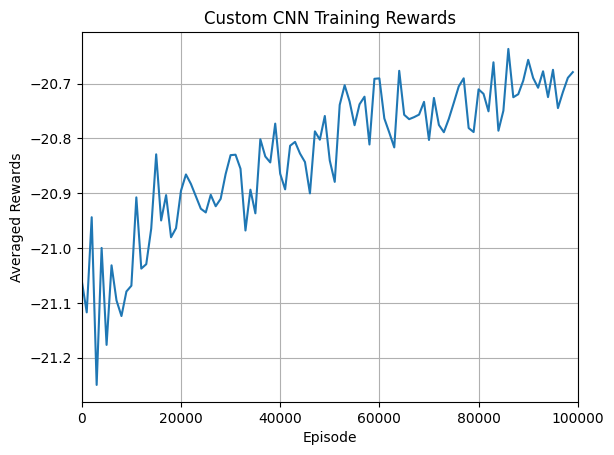

In [31]:
window_size = 1000
cumulative_sum = np.cumsum(custom_rewards)
running_avg = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size

initial_values = [np.mean(custom_rewards[:i+1]) for i in range(window_size-1)]
running_avg = np.concatenate((initial_values, running_avg))

custom_averaged_rewards = [
        np.mean(custom_rewards[i:i+window_size])
        for i in range(0, len(custom_rewards), window_size)
    ]

# Plotting rewards
plt.plot(range(0, len(custom_rewards), window_size), custom_averaged_rewards, label="Averaged Rewards")
plt.xlabel("Episode")
plt.ylabel("Averaged Rewards")
plt.title("Custom CNN Training Rewards")
plt.xlim(0, len(custom_rewards))
# plt.ylim(-25, -20)
plt.grid(True)
plt.savefig("custom_100000_rewards.png")
plt.show()

In [ ]:
custom_rewards_helped1000 = train_dqn(episodes=100000, valid_mask=True, algo_help=1000)

Streaming output truncated to the last 5000 lines.
====================NEW GAME=========================
episode  41872
====================NEW GAME=========================
episode  41873
====================NEW GAME=========================
episode  41874
====================NEW GAME=========================
episode  41875
====================NEW GAME=========================
episode  41876
====================NEW GAME=========================
episode  41877
====================NEW GAME=========================
episode  41878
====================NEW GAME=========================
episode  41879
====================NEW GAME=========================
episode  41880
====================NEW GAME=========================
episode  41881
====================NEW GAME=========================
episode  41882
====================NEW GAME=========================
episode  41883
====================NEW GAME=========================
episode  41884
====================NEW GAME========================

In [ ]:
window_size = 1000
cumulative_sum = np.cumsum(custom_rewards_helped1000)
running_avg = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size

initial_values = [np.mean(custom_rewards_helped1000[:i+1]) for i in range(window_size-1)]
running_avg = np.concatenate((initial_values, running_avg))

custom_averaged_rewards_helped1000 = [
        np.mean(custom_rewards_helped1000[i:i+window_size])
        for i in range(0, len(custom_rewards_helped1000), window_size)
    ]

# Plotting rewards
# plt.plot(rewards, label="Rewards")
# plt.plot(running_avg, label="Running Average")
plt.plot(range(0, len(custom_rewards_helped1000), window_size), custom_averaged_rewards_helped1000, label="Averaged Rewards")
plt.xlabel("Episode")
plt.ylabel("Averaged Rewards")
plt.title("DQN Training Rewards")
plt.xlim(0, len(custom_rewards_helped1000))
# plt.ylim(-25, -20)
plt.grid(True)
plt.savefig("dqn_100000_rewards.png")
plt.show()

In [ ]:
custom_rewards_helped5000 = train_dqn(episodes=100000, valid_mask=True, algo_help=5000)

In [ ]:
window_size = 1000
cumulative_sum = np.cumsum(custom_rewards_helped5000)
running_avg = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size

initial_values = [np.mean(custom_rewards_helped5000[:i+1]) for i in range(window_size-1)]
running_avg = np.concatenate((initial_values, running_avg))

custom_averaged_rewards_helped5000 = [
        np.mean(custom_rewards_helped5000[i:i+window_size])
        for i in range(0, len(custom_rewards_helped5000), window_size)
    ]

# Plotting rewards
# plt.plot(rewards, label="Rewards")
# plt.plot(running_avg, label="Running Average")
plt.plot(range(0, len(custom_rewards_helped5000), window_size), custom_averaged_rewards_helped5000, label="Averaged Rewards")
plt.xlabel("Episode")
plt.ylabel("Averaged Rewards")
plt.title("DQN Training Rewards")
plt.xlim(0, len(custom_rewards_helped5000))
# plt.ylim(-25, -20)
plt.grid(True)
plt.savefig("dqn_100000_rewards.png")
plt.show()